Traditional regression models predict the conditional mean $\mathbb E[Y∣X=x]$, or [sometimes](https://en.wikipedia.org/wiki/Quantile_regression) a few quantiles. In contrast, distributional regression attempt to learn the *entire* conditional distribution $Y|X=x$. Having access to the full distribution gives us calibrated uncertainty estimates, probabilistic forecasts, etc.

In a recent seminar I learned about engression, a lightweight and principled approach to distributional regression. Instead of predicting a parametric distribution or optimizing a likelihood, engression trains models to transform noise into samples from $Y|X=x$, using a [proper scoring rule](https://en.wikipedia.org/wiki/Scoring_rule) called the [energy score](https://sites.stat.washington.edu/raftery/Research/PDF/Gneiting2007jasa.pdf). It's implicit, generative, and remarkably straightforward to implement.

Here, I try to explain the main idea, reproduce some of the [paper](https://arxiv.org/abs/2307.00835)’s results, and discuss a few of its properties.

## In a nutshell

We consider a general class of models $\mathcal{M} = {g(x, \varepsilon)}$, where each model takes covariates $x$ and a random vector $\varepsilon$ as input. The noise vector $\varepsilon$ is drawn from a fixed distribution independent of $x$. We imagine each function $g(x, \varepsilon) \mapsto y$ in $\mathcal{M}$ as defining a conditional distribution of $Y \mid X = x$. The “best” $g$ is found by minimizing the **engression loss**:
$$
\mathbb E \left[ \left \| Y - g(X, \varepsilon) \right \| - \frac{1}{2} \left \| g(X, \varepsilon) - g(X, \varepsilon') \right \| \right]
$$

where $\varepsilon$ and $\varepsilon'$ are independent draws from the noise distribution. This is the negative of the energy score, a proper scoring rule. As a result, the authors show that the minimizer recovers the true conditional distribution $Y \mid X$ — assuming the model class $\mathcal{M}$ is expressive enough. In practice, this means using neural networks with sufficient capacity. 


Intuitively, the loss encourages two things. The first term ensures that the generated samples are close to the observed target. It pulls the predicted distribution toward the actual data. The second term penalizes collapsing all samples to a single point. It forces the model to generate diverse samples, reflecting the variability in the data. 


![If we only used the first term in the engression loss, our estimated distribution would collapse. Toy example where $Y|X \sim N(X, 0.1)$](images/loss.gif)

To minimize the empirical version of the loss using a dataset $\{(X_i, Y_i): i=1, \dots, n\}$, we sample $m$ noise vectors $\varepsilon$ *per* observation and minimize

$$
\frac{1}{n} \left [ \frac{1}{m} \sum_{j=1}^m  \| Y_i - g(X_i, \varepsilon_{i,j}) \| - \frac{1}{2m(m-1)} \sum_{j=1}^m \sum_{j'=1}^m \|g(X_i, \varepsilon_{i, j}) - g(X_i, \varepsilon_{i, j'})  \|\right]
$$

Once trained, $g$ acts as an *implicit* and *generative* model for $Y \mid X$. It doesn’t yield an explicit density $p(y \mid x)$, but we can generate samples by sampling $\varepsilon$ and feeding it into $g$. From these samples, we can estimate means, medians, confidence intervals, etc. as usual.

Note: While we focused on the main loss explored in the paper, the authors mention several generalizations in Appendix D. Specifically, the energy score is one example of a broader class of kernel scores, and engression can in principle use any proper scoring rule that characterizes a distribution (see Section 2). I wouldn’t be surprised if future work develops variants that emphasize the tails, which could be especially useful in risk-sensitive applications.


## Pre-additive noise and extrapolation

While minimizing the loss above is sufficient to learn the conditional distribution within the training range (assuming $g$ is expressive enough), the authors show that, under certain assumptions about the noise structure, engression can also support limited extrapolation.

Most regression and generative models assume that the noise is post-additive. That is, that noise $\eta$ is added after applying a nonlinear transformation to the covariates: $Y = g(X) + \eta$. Pre-additive noise instead assumes $Y = g(X + \eta)$. This helps with extrapolation because, as the authors note

>"As such, if the data
are generated according to a post-ANM, the observations for the response variable are perturbed values of
the true function evaluated at covariate values within the support. We hence generally have no data-driven
information about the behaviour of the true function outside the support. In contrast, data generated from
a pre-ANM contain response values that reveal some information beyond the support"

![](images/noise.png){width=350px, fig-align="left"}

The authors formalize this and show that under certain structural assumptions — like smoothness or monotonicity of $g$, and symmetric pre-additive noise — engression can recover aspects of $g$ beyond the training range. A key idea is that larger input noise gives you more indirect coverage of nearby regions, so the model can "see" a bit past the edge of the data. I won’t go into the technical details here, but the extrapolation results are interesting and worth checking out if you’re curious.

In [1]:
#| echo: false
#| output: false

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import pandas as pd

import math
from scipy.stats import norm

import pandas as pd

from itertools import product
from collections import defaultdict

import matplotlib.pyplot as plt

def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
set_seed(42)

## Implementation

We walk through how simple engression is to implement and attempt to reproduce Figure 4 from the paper, which highlights its extrapolation capabilities using synthetic data.

We implement $g(x, \varepsilon) \mapsto y$ as a MLP. In the paper, the authors feed the concatenated vector $[x, \varepsilon]$ into a standard (deterministic) network. To keep things flexible and modular — and since $\varepsilon$ must be sampled independently of $x$ — we can instead:

In [2]:
#| code-summary: Model definitions
#| echo: false
class ResBlock(nn.Module):

    def __init__(self, features, dropout = 0.0):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(features, features),
            nn.BatchNorm1d(features), # Use BatchNorm1d
            nn.ReLU(),
            nn.Dropout(dropout) if dropout > 0.0 else nn.Identity(),
            nn.Linear(features, features) # Second linear layer within the block
        )

    def forward(self, x):
        identity = x
        out = self.layers(x)
        return identity + out # Add the residual

class ResMLP(nn.Module):

    def __init__(self, input_dim, hidden_dim, num_residual_blocks, output_dim, dropout=0.0):
        super().__init__()

        layers = []

        # Initial layer to get from input_dim to the common hidden_dim
        layers.extend([
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout) if dropout > 0.0 else nn.Identity()
        ])

        # Add the specified number of residual blocks
        for _ in range(num_residual_blocks):
            layers.append(ResBlock(hidden_dim, dropout=dropout))

        # Final layer from the hidden dimension to output_dim
        layers.append(nn.Linear(hidden_dim, output_dim))

        # Combine all layers into a sequential model
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)
    

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, dropout=0.0):
        super().__init__()

        layers = []

        in_dim = input_dim
        for i, hidden_dim in enumerate(hidden_dims):
            layers.extend([
                nn.Linear(in_dim, hidden_dim),
                nn.ReLU(),
                nn.BatchNorm1d(hidden_dim) if len(hidden_dims) > 1 else nn.Identity(),
                nn.Dropout(dropout) if dropout > 0.0 else nn.Identity()
            ])
            in_dim = hidden_dim

        layers.append(nn.Linear(in_dim, output_dim))
        self.model = nn.Sequential(*layers)
    
    def forward(self, x): return self.model(x)

In [3]:
#| code-summary: Defining g(x, eps)
#| code-fold: show
class gConcatenate(nn.Module):
    """ g(x, eps) = g([x, eps]), where eps ~ N(0, 1) or Unif(0, 1) """

    def __init__(self, model, noise_dim, noise_type = 'normal', scale = 1.0):
        super(gConcatenate, self).__init__()
        self.model = model
        self.noise_dim = noise_dim
        self.noise_f = torch.randn if noise_type == 'normal' else torch.rand
        self.scale = scale

    def forward(self, x):
        assert len(x.shape) >= 2,'x must have at least 2 dims, where batch is the first'
        eps = self.noise_f(x.shape[0], self.noise_dim).to(x.device)
        eps = self.scale * eps
        return self.model(torch.cat([x, eps], dim = 1))
    
# example
model = MLP(1, [64, 64], 1)
g = gConcatenate(model, noise_dim = 100, noise_type = 'uniform')

Of course, there are many different ways one could define $g$ beyond concatenating the noise with the input. I’m sure future work will explore them. 

Now, define the loss function:

In [4]:
#| code-summary: engression loss
#| code-fold: show
def engression_loss(y, preds, p = 2, return_terms = False):
    """
    Args:
        y (torch.Tensor): True target values (batch_size, output_dim).
        preds (torch.Tensor): Predicted target with independently sampled noise (batch_size, m_samples, output_dim).
        p (float): The order of the norm to use for the loss calculation.
        return_terms (bool): If True, return the individual terms of the loss.
    """
    assert preds.shape[0] == y.shape[0] and preds.shape[2] == y.shape[1]
    n, m, D = preds.shape # n is batch_size, m is num_samples, D is output_dim

    # Term 1: the absolute error between the predicted and true values
    term1 = torch.linalg.vector_norm(preds - y[:, None, :], ord = p, dim = 2).mean()

    # Term 2: pairwise absolute differences between the predicted values
    term2 = torch.tensor(0.0, device = preds.device, dtype = preds.dtype)

    if m > 1:
        # cdist is convinient. The result shape before sum is (n, m, m).
        sum_pairwise_l1_dists = torch.cdist(preds, preds, p = p).sum()
        term2 = - sum_pairwise_l1_dists / (n * 2 * m * (m - 1) * D)

    
    return (term1 + term2, term1, term2) if return_terms else term1 + term2

And a simple training loop:

In [5]:
#| code-summary: Training loop
#| code-fold: show
def train(g, dl, m, lr = 0.001, epochs = 100, verbose = True):

    optimizer = torch.optim.Adam(g.parameters(), lr = lr)

    losses = []
    for _ in range(epochs):
        for x, y in dl:

            g.zero_grad()

            # Generate m samples from the model
            # shape: (batch_size, m, output_dim)
            preds = torch.stack([g(x) for _ in range(m)], dim = 1)

            loss = engression_loss(y, preds)

            loss.backward()
            optimizer.step()

            losses.append(loss.item())
            if verbose: print(loss.item())
    
    return losses

In [6]:
#| code-summary: Training loop for L2
#| echo: false
def train_l1(g, dl, lr = 0.001, epochs = 100, verbose = True):

    optimizer = torch.optim.Adam(g.parameters(), lr = lr)

    losses = []
    for _ in range(epochs):
        for x, y in dl:

            g.zero_grad()

            pred = g(x)
            # loss = F.mse_loss(pred, y)
            loss = F.l1_loss(pred, y)

            loss.backward()
            optimizer.step()

            losses.append(loss.item())
            if verbose: print(loss.item())
    
    return losses

Finally, we attempt to replicate Figure 4 from the paper using simulated data with pre-additive noise. For the `softplus` case, for example, we generate $X \sim \text{Unif}[-2, 2]$, $\eta \sim \mathcal N(0, 1)$ and set $Y = g^\ast(x + \eta)$ with $g^\ast(t) = \log(1+\exp(t))$.  We then train simple MLPs using the engression loss and evaluate their ability to recover the true median — given by $g^\ast(x)$ — especially outside the range of the training data.

In [7]:
#| code-summary: Synthetic data
#| code-fold: true
g_stars = {
    'softplus': F.softplus,
    'square': lambda x: (torch.max(x, torch.tensor(0.0)) ** 2) / 2,
    'cubic': lambda x: (x ** 3) / 3,
    'log': lambda x: (x/3 + math.log(3) - 2/3)*(x <= 2) + (torch.log(1 + x*(x > 2)))*(x > 2) 
}

x_train_lims = {
    'softplus': (-2, 2),
    'square': (0, 2),
    'cubic': (-2, 2),
    'log': (0, 2)
}

x_test_lims = {
    'softplus': (-2, 8),
    'square': (0, 6),
    'cubic': (-2, 6),
    'log': (0, 10)
}

def train_data(n, input_dim, type = 'softplus', pre_additive_noise = True):

    g_star = g_stars[type]

    a, b = x_train_lims[type]
    X = torch.rand((n, input_dim)) * (b - a) + a # Unif(a, b)

    sd = 1 if type != 'cubic' else 1.1
    eta = torch.randn((n, input_dim)) * sd
    
    if pre_additive_noise:
        Y = g_star(X + eta)
    else:
        Y = g_star(X) + eta

    return X, Y

# example
X, Y = train_data(1000, 1, type = 'softplus', pre_additive_noise = True)

/var/folders/0r/dny0wtpd4412y54gp84twsj40000gn/T/ipykernel_93296/1516664833.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_g_preds = torch.load(f'logs/saved_g_pr

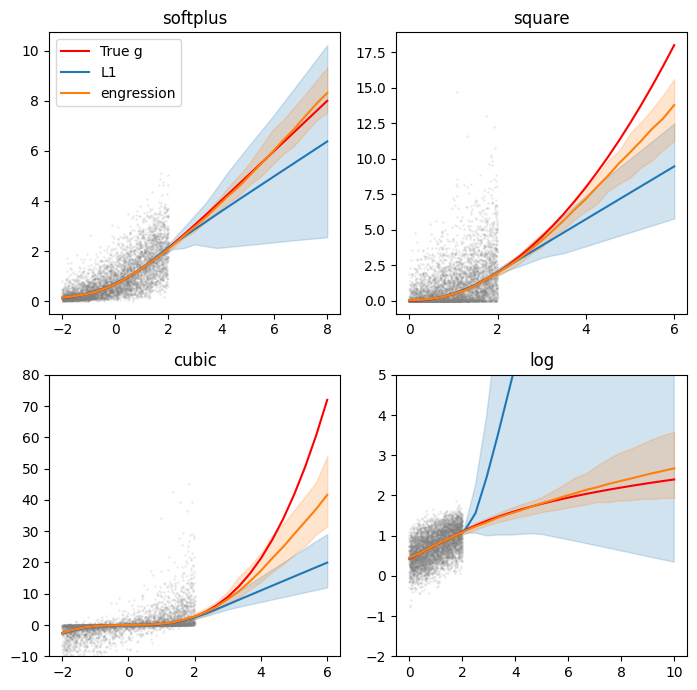

In [60]:
#| code-summary: Figure 4
#| fig-cap: "Comparing engression and L1 regression's extrapolation performance on synthetic data. Lines are predicted and true (red) conditional medians. Bands are 10-90 percentiles over 20 runs."

input_dim, hidden_dim, output_dim = 1, 128, 1
noise_dim, m_train, m_pred = 100, 2, 512

batch_size = 1024
epochs = 20

ds_size = lambda name: 50_000 if name in 'softplus/square' else 100_000 # 50k, 100k
depth = lambda name: 2 if name in 'softplus/square' else 3
hidden_dim = 100
lr = lambda name: 5e-2 #1e-3 #if name in 'softplus/square' else 1e-4

n_runs = 20
pre_additive_noise = True

saved_g_preds = {}
saved_l1_preds = {}

extra = '_post' if not pre_additive_noise else ''
saved_g_preds = torch.load(f'logs/saved_g_preds{extra}.pt')
saved_l1_preds = torch.load(f'logs/saved_l1_preds{extra}.pt')


f, axs = plt.subplots(2, 2, figsize = (7, 7))

for (name, g_star), ax in zip(g_stars.items(), axs.flatten()):

    # print(name)

    t = torch.linspace(x_test_lims[name][0], x_test_lims[name][1], 25)[:, None]

    # Cache to fix plot, etc
    if name in saved_g_preds:
        g_preds = saved_g_preds[name]

    else:
        g_preds = []
        for seed in range(n_runs):

            set_seed(seed)
            # model = MLP(input_dim + noise_dim, [hidden_dim] * depth(name), output_dim)
            model = ResMLP(input_dim + noise_dim, hidden_dim, depth(name), output_dim)
            g = gConcatenate(model, noise_dim = noise_dim, noise_type = 'normal')

            X, Y = train_data(ds_size(name), input_dim, type = name, pre_additive_noise = pre_additive_noise)
            dl = torch.utils.data.DataLoader(list(zip(X, Y)), batch_size = batch_size if batch_size else len(Y), shuffle = True, drop_last = True)

            losses = train(g, dl, m_train, epochs = epochs, verbose = False, lr = lr(name))

            # Predict the median using g: sample m_pred per point and take the median
            with torch.no_grad():
                g.eval()
                g_pred = torch.quantile(
                    torch.stack([g(t) for _ in range(m_pred)], dim = 1), q = 0.5, dim = 1
                )
                g_preds.append(g_pred)
        
        g_preds = torch.stack(g_preds)
        saved_g_preds[name] = g_preds

    # L1 baseline
    if name in saved_l1_preds:
        l1_preds = saved_l1_preds[name]
    else:
        l1_preds = []
        for seed in range(n_runs):
            set_seed(seed)
            model = ResMLP(input_dim, hidden_dim, depth(name), output_dim)
            X, Y = train_data(ds_size(name), input_dim, type = name, pre_additive_noise = True)
            dl = torch.utils.data.DataLoader(list(zip(X, Y)), batch_size = batch_size if batch_size else len(Y), shuffle = True, drop_last = True)
            l1_losses = train_l1(model, dl, epochs = epochs, verbose = False, lr = lr(name))

            with torch.no_grad():
                model.eval()
                l1_preds.append(model(t))

        l1_preds = torch.stack(l1_preds)
        saved_l1_preds[name] = l1_preds


    X, Y = train_data(ds_size(name), 1, type = name, pre_additive_noise = True)
    ax.scatter(X[:5000], Y[:5000], color = 'gray',  alpha = 0.1, s = 1)
    ax.plot(t, g_star(t), label = f'True g', color = 'red')

    ax.plot(t, l1_preds.mean(dim = 0), color = 'tab:blue', label = 'L1')
    ax.fill_between(t.flatten(),
        l1_preds.quantile(0.10, dim = 0).flatten(),
        l1_preds.quantile(0.90, dim = 0).flatten(),
        alpha = 0.2, color = 'tab:blue'
    )

    ax.plot(t, g_preds.mean(dim = 0), color = 'tab:orange', label = 'engression')
    ax.fill_between(t.flatten(),
        g_preds.quantile(0.10, dim = 0).flatten(),
        g_preds.quantile(0.90, dim = 0).flatten(),
        alpha = 0.2, color = 'tab:orange'
    )
    ax.set_title(name)


axs[0, 0].legend()
axs[1, 1].set_ylim((-2, 5))
axs[1, 0].set_ylim((-10, 80))

f.tight_layout()
f.savefig(f'images/figure4{extra}.png', dpi = 300, bbox_inches = 'tight')


torch.save(saved_g_preds, f'logs/saved_g_preds{extra}.pt')
torch.save(saved_l1_preds, f'logs/saved_l1_preds{extra}.pt')

We find, as the authors do, that while both methods perform similarly in-domain, engression is much better extrapolating than L1 regression — at least for monotone and pre-additively generated data. 

::: {.callout-note collapse="true" title="What if the data is not pre-additive?" icon=false}

If we generate the synthetic data with post-additive noise instead, we see that engression looses its extrapolation capability — in accordance with the theory presented in the paper. 

![Figure 4 repeated with data generated with post-additive noise instead.](images/figure4_post.png)

A natural question, then, is whether one can diagnose whether the noise in a real dataset is pre- or post-additive. The paper doesn’t address this directly, but it's an important question.
:::

While reproducing Figure 4, we also noted a few practical details that matter more than expected. Despite the simplicity of the functions, the authors used between 50k and 100k samples, depending on the function, and relatively large networks. In our experiments, the cubic and logarithmic scenarios struggled with extrapolation until we added residual connections. Also, the noise dimension was set to 100, which seems surprisingly high but turned out to be important.

In [ ]:
#| code-summary: Play with hidden and noise dims
#| echo: false
input_dim, hidden_dim, output_dim = 1, 128, 1
noise_dim, m_train, m_pred = 1, 2, 512

batch_size = 1024
epochs = 20

ds_size = lambda name: 50_000 if name in 'softplus/square' else 100_000 # 50k, 100k
depth = lambda name: 2 if name in 'softplus/square' else 3

lr = lambda name: 1e-3 #1e-3 #if name in 'softplus/square' else 1e-4

n_runs = 10
pre_additive_noise = True
extra = '_post' if not pre_additive_noise else ''

name = 'square'
t = torch.linspace(x_test_lims[name][0], x_test_lims[name][1], 25)[:, None]

results = {}

for hidden_dim, noise_dim, seed in product([32, 64, 128, 256, 512], [2, 10, 50, 100, 200], range(n_runs)):

    set_seed(seed)
    model = MLP(input_dim + noise_dim, [hidden_dim] * depth(name), output_dim)
    # model = ResMLP(input_dim + noise_dim, hidden_dim, depth(name), output_dim)
    g = gConcatenate(model, noise_dim = noise_dim, noise_type = 'normal')

    X, Y = train_data(ds_size(name), input_dim, type = name, pre_additive_noise = pre_additive_noise)
    dl = torch.utils.data.DataLoader(list(zip(X, Y)), batch_size = batch_size if batch_size else len(Y), shuffle = True, drop_last = True)

    losses = train(g, dl, m_train, epochs = epochs, verbose = False, lr = lr(name))

    # Predict the median using g: sample m_pred per point and take the median
    with torch.no_grad():
        g.eval()
        results[hidden_dim, noise_dim, seed] = torch.quantile(
            torch.stack([g(t) for _ in range(m_pred)], dim = 1), q = 0.5, dim = 1
        ).clone()

torch.save(results, f'logs/hidden_noise_dims{extra}.pt')

<Axes: xlabel='noise_dim', ylabel='hidden_dim'>

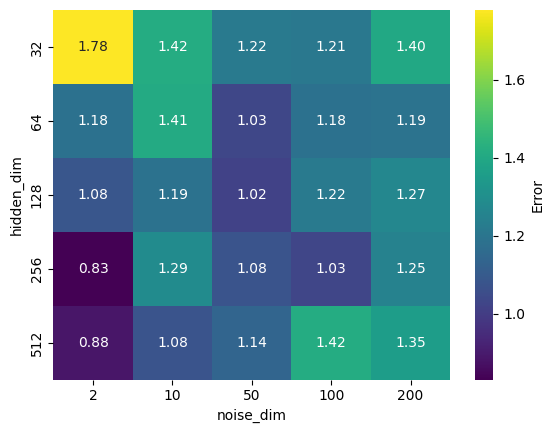

In [ ]:
#| code-summary: Figure 5
#| fig-cap: "Varying the hidden and noise dimensions of a 1 layer MLP predicting the `square` data. We show the absolute error between the predicted and true median, averaged over 10 runs. "
#| echo: false
#| output: false
results = torch.load(f'logs/hidden_noise_dims{extra}.pt')
df = []
for (hidden_dim, noise_dim, seed), v in results.items():
    error = (g_stars[name](t) - v).abs().mean().item()
    df.append((hidden_dim, noise_dim, seed, error))

df = pd.DataFrame(df, columns = ['hidden_dim', 'noise_dim', 'seed', 'error'])

import seaborn as sns
# Heatmap of hidden_dim, noise_dim -> error
sns.heatmap(
    df.pivot_table(index = 'hidden_dim', columns = 'noise_dim', values = 'error'),
    cmap = 'viridis',
    cbar_kws={'label': 'Error'},
    annot = True,
    fmt = '.2f'
)


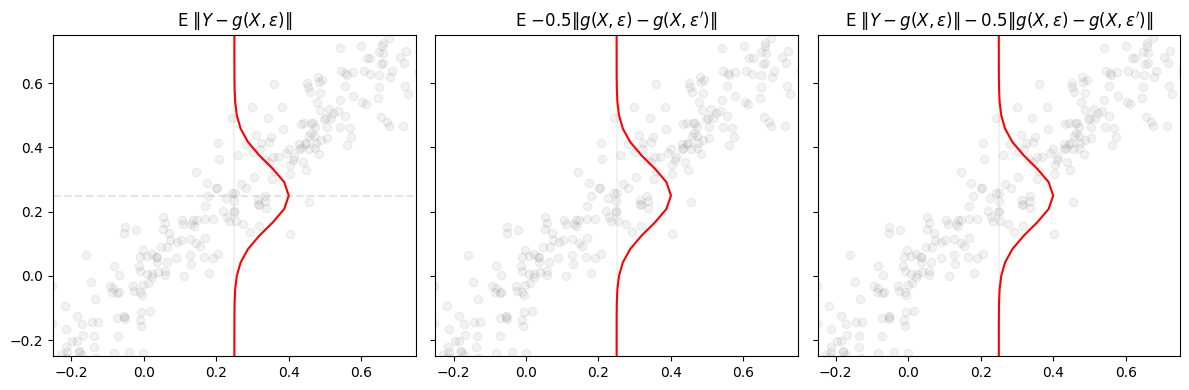

MovieWriter imagemagick unavailable; using Pillow instead.


In [ ]:
#| code-summary: Generate GIF illustrating components of loss function
#| echo: false
#| output: false


# We simulate Y|X ~ N(X, 0.1)
n = 10_000
X = torch.rand(n) * 2 - 1
Y = X + (torch.randn_like(X) * 0.1)
X, Y = X[:, None], Y[:, None]

m = 10 # number of samples to generate

# Estimated Y|X densities
# [first, second loss components] = list of [(est_density, bin_edges)], one per batch
densities = {}

input_dim, hidden_dim, output_dim = 1, 64, 1
noise_dim = 50
mini_batch_size = 250

for first, second in [(True, False), (False, True), (True, True)]:

    dl = torch.utils.data.DataLoader(list(zip(X, Y)), batch_size = mini_batch_size, shuffle = False)
    model = MLP(input_dim + noise_dim, [hidden_dim], output_dim)
    g = gConcatenate(model, noise_dim = noise_dim)

    optimizer = torch.optim.Adam(g.parameters())

    _densities = []
    for _ in range(20):
        for x, y in dl:

            g.zero_grad()

            # Generate m samples from the model
            preds = torch.stack([g(x) for _ in range(m)], dim = 1)
            _, first_term, second_term = engression_loss(y, preds, return_terms = True)
            loss = 0
            if first: loss += first_term
            if second: loss += second_term

            loss.backward()
            optimizer.step()

            with torch.no_grad():
                # estimate the density
                samples = g(torch.ones(10000, 1) * 0.25).cpu().numpy()
                est_density, bin_edges = np.histogram(samples, bins=25, density=True)
                est_density = est_density / np.sum(est_density)  # Normalize the histogram

                _densities.append((est_density, bin_edges))
        
        densities[(first, second)] = _densities


# Plot animation
from matplotlib.animation import FuncAnimation
from scipy.stats import norm

fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)

# Get the theoretical density
y_vals = np.linspace(0.25 - 0.5, 0.25 + 0.5, 25)
pdf = norm.pdf(y_vals, loc=0.25, scale=0.1)
density = pdf / pdf.sum()
density_scaled = density / density.max() * 0.15


# Set up the plot limits and labels for each subplot
for ax, title in zip(axs, [
    "E $\\| Y - g(X, \\varepsilon) \\|$",
    "E $-0.5\\| g(X, \\varepsilon) - g(X, \\varepsilon\') \\|$",
    'E $\\| Y - g(X, \\varepsilon) \\| -0.5\\| g(X, \\varepsilon) - g(X, \\varepsilon\') \\|$']):

    ax.scatter(X[:500], Y[:500], alpha=0.1, color='gray')
    ax.set_xlim(0.25 - 0.5, 0.25 + 0.5)
    ax.set_ylim(0.25 - 0.5, 0.25 + 0.5)
    ax.set_title(title)
    ax.axvline(x=0.25, color='gray', alpha = 0.1)

axs[0].axhline(y = 0.25, color='gray', alpha=0.2, linestyle='—')

# Initialize lines for true and estimated densities for each subplot
true_density_lines = []
est_density_lines = []
for ax in axs:
    true_density_line, = ax.plot([], [], color='red')
    est_density_line, = ax.plot([], [], color='blue')
    true_density_lines.append(true_density_line)
    est_density_lines.append(est_density_line)

# Initialize the animation
def init():
    for true_density_line, est_density_line in zip(true_density_lines, est_density_lines):
        true_density_line.set_data(0.25 + density_scaled, y_vals)
        est_density_line.set_data([], [])
    return true_density_lines + est_density_lines

# Update function for the animation
def update(frame):
    for (key, est_density_line) in zip([(True, False), (False, True), (True, True)], est_density_lines):
        est_density, bin_edges = densities[key][frame]
        est_density_scaled = est_density / est_density.max() * 0.15
        est_density_line.set_data(0.25 + est_density_scaled, bin_edges[:-1])
    return est_density_lines

# Create the animation
n_frames = len(densities[True, True])
ani = FuncAnimation(fig, update, frames = range(0, n_frames, n_frames // 25), init_func=init, blit=True) #range(len(densities[(True, False)]))

# Display the animation
fig.tight_layout()
plt.show()

# Save the animation as a GIF
ani.save('loss.gif', writer='imagemagick', fps=10)

## Hyperparameters

Engression introduces a couple of hyperparameters related to the noise vectors ($\varepsilon$) sampled during training: namely, $m$, the number of noise samples per example, and the distribution from which $\varepsilon$ is drawn. For example, in their synthetic data experiments, the authors set $m = 2$ and sample $\varepsilon \sim \text{Unif}[0, 1]^{100}$.

The parameter $m$ controls an accuracy–compute trade-off. Increasing $m$ means we obtain a better Monte Carlo estimate of the population engression loss, and hence of the conditional distribution. However, this also increases compute:
the cost of computing the loss grows linearly in $m$ for the first term but quadratically for the second, since we compute pairwise distances.

That said, since these are Monte Carlo estimates, we expect diminishing returns as $m$ increases. Another consolation point is that we can combat the quadratic cost by training for more epochs, at the expense of noisier gradients. This allows the model to revisit each example with different noise vectors, increasing the "effective" $m$. 

To test this, we vary $m$ on a toy example. We observe that, given enough data and epochs, all runs eventually reach similar loss values. However, models with higher $m$ converge faster and more stably. Interestingly, the conditional median tends to be learned first, with the tails filling in later.

<!-- TODO find reference pointers for last sentence -->

In [10]:
#| code-summary: Vary $m$ on toy data
n = 5_000
X = torch.rand(n) * 2 - 1               # X ~ Unif(-1, 1)
Y = X + (torch.randn_like(X) * 1)       # Y|X ~ N(X, 1)
X, Y = X[:, None], Y[:, None]

t = torch.linspace(-1, 1, 25)[:, None]

# True Y|X quantiles if we assume Y|X ~ N(X, 1)
qs = [0.1, 0.5, 0.9]
true_quantiles = {q: t + norm.ppf(q) for q in qs}

# Estimated Y|X quantiles
# [m_train, quantile level] = list of [est quantile], one per batch
quantiles = {}

input_dim, hidden_dim, output_dim = 1, 64, 1
noise_dim = 50
mini_batch_size = 32
m_pred = 512

# noise_scale = 1

stats = defaultdict(list)

m_trains = [2, 4, 8, 16]
noise_scales = [0.1, 1, 2, 4]

for m_train, noise_scale in product(m_trains, noise_scales):

    set_seed(69)
    dl = torch.utils.data.DataLoader(list(zip(X, Y)), batch_size = mini_batch_size, shuffle = False)
    model = ResMLP(input_dim = input_dim + noise_dim, hidden_dim = hidden_dim, num_residual_blocks = 2, output_dim = output_dim)
    g = gConcatenate(model, noise_dim = noise_dim, scale = noise_scale)

    optimizer = torch.optim.Adam(g.parameters(), lr = 1e-4)


    for _ in range(3):
        for x, y in dl:

            g.zero_grad()

            # Generate m samples from the model
            preds = torch.stack([g(x) for _ in range(m_train)], dim = 1)
            loss, loss_1, loss_2 = engression_loss(y, preds, return_terms = True)
            loss.backward()
            optimizer.step()

            with torch.no_grad():

                q_losses = []
                preds = torch.stack([g(t) for _ in range(m_pred)], dim = 1)
                for q in qs:
                    pred_quantile = torch.quantile(preds, q = q, dim = 1)
                    quantiles[m_train, noise_scale, q] = quantiles.get((m_train, noise_scale, q), []) + [pred_quantile]
                    
                    if q in true_quantiles:
                        stats[m_train, noise_scale, q].append(
                            (true_quantiles[q] - pred_quantile.mean(dim = 0)).flatten().abs().mean().item()
                        )

                stats[m_train, noise_scale, 'loss'].append(loss.item())
                stats[m_train, noise_scale, 'loss_1'].append(loss_1.item())
                stats[m_train, noise_scale, 'loss_2'].append(loss_2.item())

torch.save((quantiles, stats), 'logs/m_noise_scale.pt')

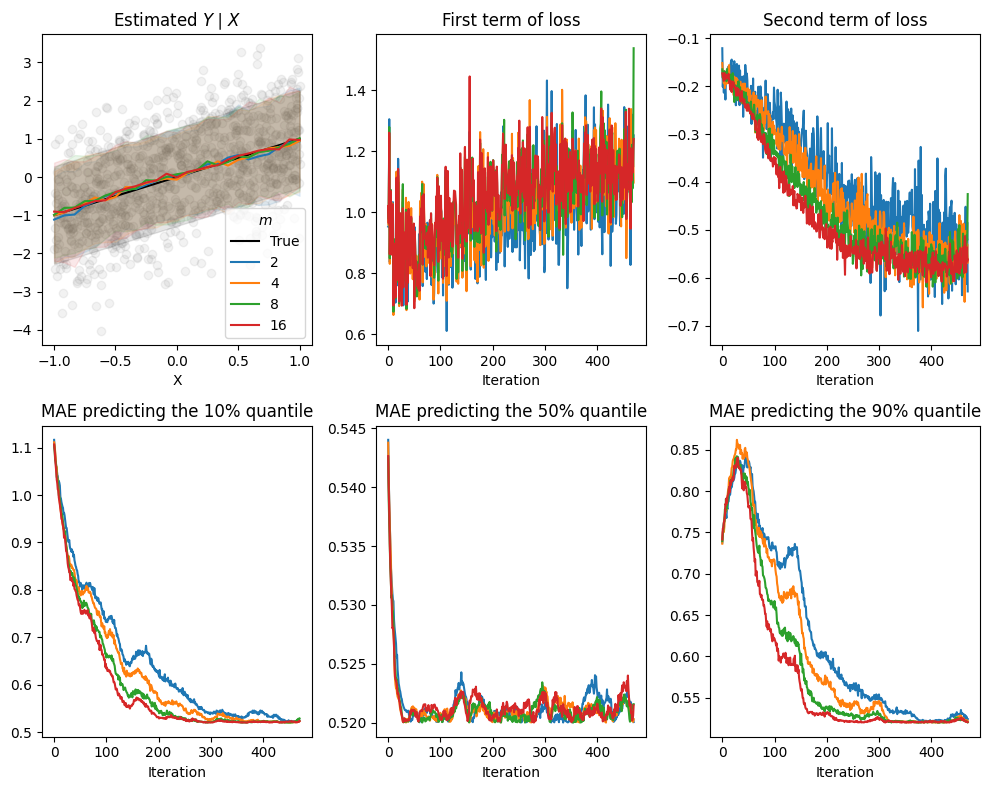

In [9]:
#| fig-cap: "Effects of varying $m$ on a simple example. Increasing $m$ yields more stable losses and faster reduction in the error estimating $Y|X$ quantiles." 
#| echo: false
quantiles, stats = torch.load('logs/m_noise_scale.pt', weights_only = False)

m_trains = [2, 4, 8, 16]
noise_scales = [0.1, 1, 2, 4]

n = 5_000
X = torch.rand(n) * 2 - 1               # X ~ Unif(-1, 1)
Y = X + (torch.randn_like(X) * 1)       # Y|X ~ N(X, 1)
X, Y = X[:, None], Y[:, None]

t = torch.linspace(-1, 1, 25)[:, None]

# True Y|X quantiles if we assume Y|X ~ N(X, 1)
qs = [0.1, 0.5, 0.9]
true_quantiles = {q: t + norm.ppf(q) for q in qs}


colors = dict(zip(m_trains, ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']))
f, axs = plt.subplots(2, 3, figsize=(10, 8))

noise_scale = 0.1

ax = axs[0, 0]
ax.scatter(X[:1000], Y[:1000], alpha=0.1, color='gray')
ax.plot(t, true_quantiles[0.5], label = f'True', color = 'black')
ax.fill_between(t.flatten(),
    true_quantiles[0.1].flatten(),
    true_quantiles[0.9].flatten(),
    alpha = 0.1, color = 'black'
)

for m_train in m_trains:
    ax.plot(t, quantiles[m_train, noise_scale, 0.5][-1], label = f'{m_train}', color = colors[m_train])
    ax.fill_between(t.flatten(),
        quantiles[m_train, noise_scale, 0.1][-1].flatten(),
        quantiles[m_train, noise_scale, 0.9][-1].flatten(),
        alpha = 0.1, color = colors[m_train]
    )

ax.legend(title = '$m$')
ax.set_xlabel('X'); #ax.set_ylabel('Y')
ax.set_title('Estimated $Y \\mid X$')


ax = axs[0, 1]
for m_train in m_trains:
    ax.plot(stats[m_train, noise_scale, 'loss_1'], label = f'{m_train}', color = colors[m_train])

ax.set_title('First term of loss')
ax.set_xlabel('Iteration')
# ax.legend(title = '$m_\\text{train}$')

ax = axs[0, 2]
for m_train in m_trains:
    ax.plot(stats[m_train, noise_scale, 'loss_2'], label = f'{m_train}', color = colors[m_train])

ax.set_title('Second term of loss')
ax.set_xlabel('Iteration')


ax = axs[1, 0]

for ax, q in zip(axs[1, :], [0.1, 0.5, 0.9]):
    for m_train in m_trains:
        ax.plot(stats[m_train, noise_scale, q], label = f'{m_train}', color = colors[m_train])

    # ax.set_title(f'{(q * 100):.0f}th percentile abs error')
    ax.set_title(f'MAE predicting the {q:.0%} quantile')
    ax.set_xlabel('Iteration')

f.tight_layout()

While the only formal requirement on the noise distribution is that $\varepsilon$ be independent of $x$, its specific choice can have important practical implications. For instance, the authors show that increasing the standard deviation of $\varepsilon$ can improve extrapolation.

In our toy setup, the effect of $\sigma_\varepsilon$ resembles a smoothing or locality knob [^1]: smaller values produce predictions that are tightly concentrated around the training targets, encouraging sharp interpolation. Larger $\sigma_\varepsilon$ values lead to more diffuse predictions, smoothing out local variations and potentially blurring fine-grained structure. While this may benefit extrapolation in other settings (as shown in the paper), here it hints at a trade-off: excessive noise could dampen the model’s ability to fit in-domain details.

[^1]: Imagining one-dimensional $\varepsilon$ and $g(x + \varepsilon)$ (instead of concatenating) should help with this intuition. 

<>:20: SyntaxWarning: invalid escape sequence '\s'
<>:20: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_1033386/2602611564.py:20: SyntaxWarning: invalid escape sequence '\s'
  plt.title(f'$Y \\mid X \sim N(X, \\sigma_\\varepsilon)$')


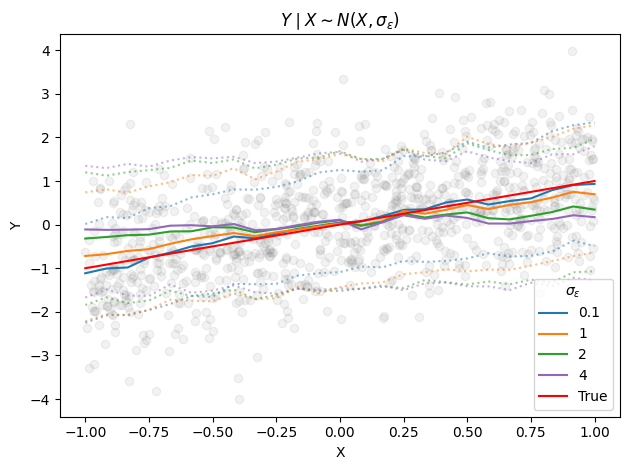

In [ ]:
#| fig-cap: "Conditional medians learned after training with gaussian noise with different $\\sigma_\\varepsilon$, with $m=2$." 
#| echo: false
colors = dict(zip(noise_scales, ['tab:blue', 'tab:orange', 'tab:green', 'tab:purple', 'tab:purple']))

# for m_train in m_trains:

#     plt.figure()
m_train = 2

for noise_scale in noise_scales:
    plt.plot(t, quantiles[m_train, noise_scale, 0.5][-1], label = f'{noise_scale}', color = colors[noise_scale])
    plt.plot(t, quantiles[m_train, noise_scale, 0.1][-1], color = colors[noise_scale], linestyle = ':', alpha = 0.50)
    plt.plot(t, quantiles[m_train, noise_scale, 0.9][-1], color = colors[noise_scale], linestyle = ':', alpha = 0.50)

plt.scatter(X[:1000], Y[:1000], alpha=0.1, color='gray')
plt.plot(t, true_quantiles[0.5], label = f'True', color = 'red')

plt.legend(title = '$\\sigma_\\varepsilon$')
plt.xlabel('X'); plt.ylabel('Y')
plt.title(f'$Y \\mid X \sim N(X, \\sigma_\\varepsilon)$')
plt.tight_layout()

Above, we fixed $m$ and varied $\sigma_\varepsilon$. But in general, $m$, $\sigma_\varepsilon$, and the dimensionality of $\varepsilon$ appear to be interdependent. For example (speculating), increasing $\sigma_\varepsilon$ might require lower noise dimensionality to avoid exploding variance, or perhaps lower $m$ values suffer more under high-variance noise due to noisier gradient estimates.

It would be interesting to study the interplay between them. Tuning them jointly will likely be important for practical applications.

## Real data

So far we've focused on toy problems and synthetic experiments, but the authors of the engression paper also evaluate the method on real datasets in Section 4. They benchmark engression on both univariate and multivariate tasks — including point prediction, interval estimation, and full distributional modeling — and compare it against standard approaches like L2 and L1 regression, as well as [quantile regression forests](https://www.jmlr.org/papers/volume7/meinshausen06a/meinshausen06a.pdf). Engression consistently outperforms these baselines, especially when extrapolating.

In their experiments, the authors use a MLP trained directly on the tabular inputs. But it's [well known](https://arxiv.org/abs/2207.08815) that deep nets are not particularly strong on tabular data (although this might be [changing](https://www.nature.com/articles/s41586-024-08328-6)). That said, there's nothing inherent in engression that requires you to use a neural network end-to-end. You can just as easily treat the engression-trained MLP as a modular head and stack it on top of any strong tabular model.

![We can stack engression on top of any base model](images/stacking_engression.svg)

I [tried](_temperature.ipynb) this idea on a probabilistic forecasting [competition](https://www.kaggle.com/competitions/probabilistic-forecasting-i-temperature/overview), where the goal was to predict a set of conditional quantiles (0.05 through 0.95). The winning submission used [catboost](https://catboost.ai/) with a multi-quantile loss, followed by [conformal prediction](https://en.wikipedia.org/wiki/Conformal_prediction) to generate calibrated intervals. I took their base CatBoost model — which outputs quantile predictions — and replaced the conformalization step with a small MLP trained using engression (i.e., with the energy score). It ended up beating the winning model’s [CRPS score](https://en.wikipedia.org/wiki/Scoring_rule#Conditional_continuous_ranked_probability_score) by about 0.04 on the private test set, without any additional hyperparameter tuning. (For context, the difference between first and second place was 0.06.)

I think this kind of stacking could make engression much more versatile in practice. I'm looking forward to exploring more applications.

## Final thoughts

Engression's main strength lies in its simplicity and flexibility. It requires no parametric assumptions on the output distribution, no likelihood computations, no adversarial training, and no architectural constraints like invertibility. It scales naturally to multivariate $X$ and $Y$, and at test time, sampling is fast and easily parallelizable. These properties make it particularly appealing for tasks like forecasting, simulation, or structured prediction, where calibrated uncertainty is important but explicit density evaluation is not.

That said, engression comes with tradeoffs. Because it models distributions implicitly — without yielding closed-form densities — it’s less suitable for inference tasks that rely on likelihoods. Its one-shot sampling may also struggle with complex, multimodal distributions, as the energy score tends to cover modes rather than [seek them](https://sander.ai/2020/03/24/audio-generation.html#mode-covering-vs-mode-seeking-behaviour). In such cases, methods like diffusion models or normalizing flows might offer better performance, albeit at higher computational and implementation cost.

Encouragingly, the authors have begun to explore extensions. A recent [paper](https://arxiv.org/abs/2502.13747v1) proposes a multi-step version of engression that improves performance on challenging tasks. Another work introduces [distributional autoencoders](https://arxiv.org/abs/2404.13649), combining engression with dimensionality reduction.

Overall, engression is a clever and lightweight approach to distributional regression. I’m excited to see where future research and applications take it. The [paper](https://arxiv.org/abs/2307.00835) is very readable, and the authors have released their code [here](https://github.com/xwshen51/engression/) if you want to play with it. I’m also learning about python packaging — here’s a [small one](https://github.com/emiliocantuc/engression-pytorch) with the loss and a few wrappers for convenience.


---

Thanks for reading! If you spot any errors, or have comments or suggestions, feel free to reach out.
